## Introduction

I live in Moscow and metro system is very vast and developed here. Lets have a look at the neighborhoods surrounding metro stations and classify them. They can be divided in mostly residential, business or commercial areas, surrounding them. Venues positioning arount station determine why and how people use it. If professional places  zer not in a neighborhood its residents are likely to travel to other areas for work. This creates daily migrations of people.
WIth analysis of this data it is possible to classify stations by their primary usage. It could be useful for city planners to determine where from and where to people are most likely to travel for work and leisure, plan further extension of the network and find places for new development.
I would like to perform such analysis for Southern Moscow, where I live.

It could be very useful for people who are planning to rent an appartment in this area, to choose the metro station.
It could also be useful for companies, which choose a place for their office.

## Data

I will use data on the location of stations and on the venues closest to them. 
Stations list and locations would be taken from Wikipedia and pgeocoder.
Foursquare API will be used to explore venue types around each station. Foursquare has high-level venue categories and sub-categories.

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

from bs4 import BeautifulSoup

import re

ERROR: Invalid requirement: '#'



Libraries imported.


List of Moscow Metro stations and their geographical coordinates may be retreived from WIKI

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'

In [7]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'lxml')

# get the table containing the postal codes
stations_table = wiki_doc.find('table', {'class': 'wikitable sortable'})

In [21]:
# Grab English name, Russian name and coordinates (convert to comma-separated) from list
indices = [0,1,6]

stations_df = pd.DataFrame(columns=['Line','English name','Russian name','Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    line = re.search('#(.+?)\s', tr.find('a')['title']).group(1)
    cells = tr.find_all('td')
    #ignore cells that don't have coordinates
    if cells[6].text.strip() != '':
        stations_df = stations_df.append({
            'English name': cells[0].text.strip(),
            'Russian name': cells[1].text.strip(),
            'Coordinates': cells[6].find('span', {'class': 'geo'}).text.strip().replace('; ',','),
            'Line': line
        }, ignore_index=True)    
        


,Line,English name,Russian name,Coordinates
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342"
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448"
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151"
3,1,Sokolniki,Сокольники,"55.7888,37.6802"
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673"


In [36]:
stations_df.head()

,Line,English name,Russian name,Coordinates
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342"
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448"
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151"
3,1,Sokolniki,Сокольники,"55.7888,37.6802"
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673"


In [14]:
prev_line = line
prev_coordinates = latlong   

We can visualize all the stations and lines on the Map usin Folium. 

In [13]:
# Line color codes
line_colors = {
    '1':'#EF161E',
    '2':'#2DBE2C',
    '3':'#0078BE',
    '4':'#00BFFF',
    '5':'#8D5B2D',
    '6':'#ED9121',
    '7':'#800080',
    '8':'#FFD702',
    '8A':'#FFD702',
    '9':'#999999',
    '10':'#99CC00',
    '11':'#82C0C0',
    '11A':'#82C0C0',
    '12':'#A1B3D4',
    '13':'#9999FF',
    '14':'#FFFFFF',
    '15':'#DE64A1'
}

#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)
#add markers
for line, station, coordinates in zip(stations_df['Line'], stations_df['English name'], stations_df['Coordinates']):
    latlong = [float(x) for x in coordinates.split(',')]
    #Also add a 500-meter circle around the station to visualize our neighborhoods
    #folium.Circle(
    #    latlong,        
    #    radius=1000,
    #    color=line_colors[line]
    #).add_to(map_moscow_metro)
    #Add marker with popup
    folium.Circle(
        latlong,
        popup=station,
        radius=20,
        color=line_colors[line]
    ).add_to(map_moscow_metro)
    if line != prev_line:
        prev_coordinates = None    
    if prev_coordinates != None:
        folium.PolyLine([prev_coordinates, latlong], color=line_colors[line]).add_to(map_moscow_metro)    
    prev_line = line
    prev_coordinates = latlong    

def draw_lines(dataframe, map_object, opacity=1):
    prev_coordinates = None
    prev_line = '1'
    for line, coordinates in zip(dataframe['Line'], dataframe['Coordinates']):
        latlong = [float(x) for x in coordinates.split(',')]
        #don't draw line if line number changed
        if line != prev_line:
            prev_coordinates = None
        if prev_coordinates != None:
            folium.PolyLine([prev_coordinates, latlong], color=line_colors[line], opacity=opacity).add_to(map_object)
        prev_line = line
        prev_coordinates = latlong    
    
    #special case for two circle lines
    for line in ['5','14']:
        first_station = dataframe[dataframe['Line'] == line].iloc[0]['Coordinates']
        last_station = dataframe.iloc[dataframe[stations_df['Line'] == line].last_valid_index()]['Coordinates']    
        print()
        print()
        folium.PolyLine([[float(x) for x in first_station.split(',')],
                         [float(x) for x in last_station.split(',')]],
                        color=line_colors[line], opacity=opacity).add_to(map_object)

draw_lines(stations_df, map_moscow_metro)
map_moscow_metro

Lets do some additional work on data to be able to process it properly. 

In [35]:
st['lat'], st['lon'] = st['Coordinates'].str.split(',', 1).str
st.head()

C:\Temp\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Line,English name,Russian name,Coordinates,lat,lon
0,1,Bulvar Rokossovskogo,Бульвар Рокоссовского,"55.8148,37.7342",55.8148,37.7342
1,1,Cherkizovskaya,Черкизовская,"55.8038,37.7448",55.8038,37.7448
2,1,Preobrazhenskaya Ploshchad,Преображенская площадь,"55.7963,37.7151",55.7963,37.7151
3,1,Sokolniki,Сокольники,"55.7888,37.6802",55.7888,37.6802
4,1,Krasnoselskaya,Красносельская,"55.7801,37.6673",55.7801,37.6673


Cut off stations that are not in South-Western district of Moscow as we would like to analyze only South-Western district

In [17]:
top_border = '55.706' 

bottom_border = '55.531'

left_border = '37.488'

right_border = '37.603'

In [37]:
indexNames = st[ st['lat'] > '55.706'].index
indexNames.append(st[ st['lat'] < '55.531'].index)
indexNames.append(st[ st['lon'] > '37.603'].index)
indexNames.append(st[ st['lon'] < '37.488'].index)
indexNames

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            249, 250, 251, 252, 253, 254, 255, 256, 258, 259],
           dtype='int64', length=195)

In [38]:
stations_df.drop(indexNames , inplace=True)
stations_df

,Line,English name,Russian name,Coordinates
16,1,Universitet,Университет,"55.6926,37.5333"
17,1,Prospekt Vernadskogo,Проспект Вернадского,"55.6771,37.5060"
18,1,Yugo-Zapadnaya,Юго-Западная,"55.6637,37.4833"
19,1,Troparyovo,Тропарёво,"55.6459,37.4725"
20,1,Rumyantsevo,Румянцево,"55.6330,37.4419"
21,1,Salaryevo,Саларьево,"55.6227,37.4240"
37,2,Tekhnopark,Технопарк,"55.6950,37.6641"
38,2,Kolomenskaya,Коломенская,"55.6785,37.6638"
39,2,Kashirskaya,Каширская,"55.6551,37.6487"
40,2,Kantemirovskaya,Кантемировская,"55.6358,37.6564"


Now lets use Foursquare API to retrive information on companies and ventures in the area.
Most precisely, lets look at types and categories on venues available in Foursquare.

In [39]:

#Foursquare parameters
LIMIT = 100
RADIUS = 500
CLIENT_ID = 'WYBJRRGI1MEJSTZPPD2WP5UKT5OQJDPBY11VPJGZ5JRU3UCY' 
CLIENT_SECRET = 'Z3O1MNIRARNUCXMTYQ1AHXXX2QC23QAUNUDW5LWBSREW1P3J' 
VERSION = '20190425'
#Foursquare API URL templates
FS_EXPLORE_URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'

In [40]:

categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [41]:
len(results['response']['categories'])

10

In [42]:
# Let's print only the top-level categories and their IDs and also add them to categories_list
categories_list = []
def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Methodology

We will use Foursquare API to get the number of venues for area per category.

In [43]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [44]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [72]:
stations_venues_df1.reset_index(inplace = True)

In [50]:
stations_venues_df1 = stations_venues_df.copy()

In [70]:
stations_venues_df1.drop(['index'], axis = 1, inplace = True) 

In [64]:
stations_venues_df3 = stations_venues_df1.copy()

In [73]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df1.iterrows():
    print(i)
    for c in categories_list:        
        stations_venues_df1.loc[i, c[0]] = get_venues_count(stations_venues_df1.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df1.to_csv('stations_venues.csv')

0
1


Lets have a look at our retrieved data.

In [122]:
station_venues_df

,Line,English name,Russian name,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1,Universitet,Университет,"55.6926,37.5333",15,24,0,45,11,28,80,35,68,14
1,1,Prospekt Vernadskogo,Проспект Вернадского,"55.6771,37.5060",11,32,0,50,7,33,90,38,75,10
2,1,Yugo-Zapadnaya,Юго-Западная,"55.6637,37.4833",4,8,0,44,6,18,88,4,59,15
3,1,Troparyovo,Тропарёво,"55.6459,37.4725",7,11,0,34,12,36,62,22,83,11
4,1,Rumyantsevo,Румянцево,"55.6330,37.4419",3,5,0,29,6,30,61,33,78,9
5,1,Salaryevo,Саларьево,"55.6227,37.4240",9,4,0,20,11,9,37,11,77,12
6,2,Tekhnopark,Технопарк,"55.6950,37.6641",6,8,0,11,4,26,40,15,43,12
7,2,Kolomenskaya,Коломенская,"55.6785,37.6638",7,12,0,20,5,18,47,27,52,14
8,2,Kashirskaya,Каширская,"55.6551,37.6487",4,8,0,35,9,31,69,21,70,17
9,2,Kantemirovskaya,Кантемировская,"55.6358,37.6564",6,2,0,28,11,37,61,30,66,17


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

## Basic cleanup & Exploratory analysis

We may visualize data with the boxplot to show if there any empty categories.

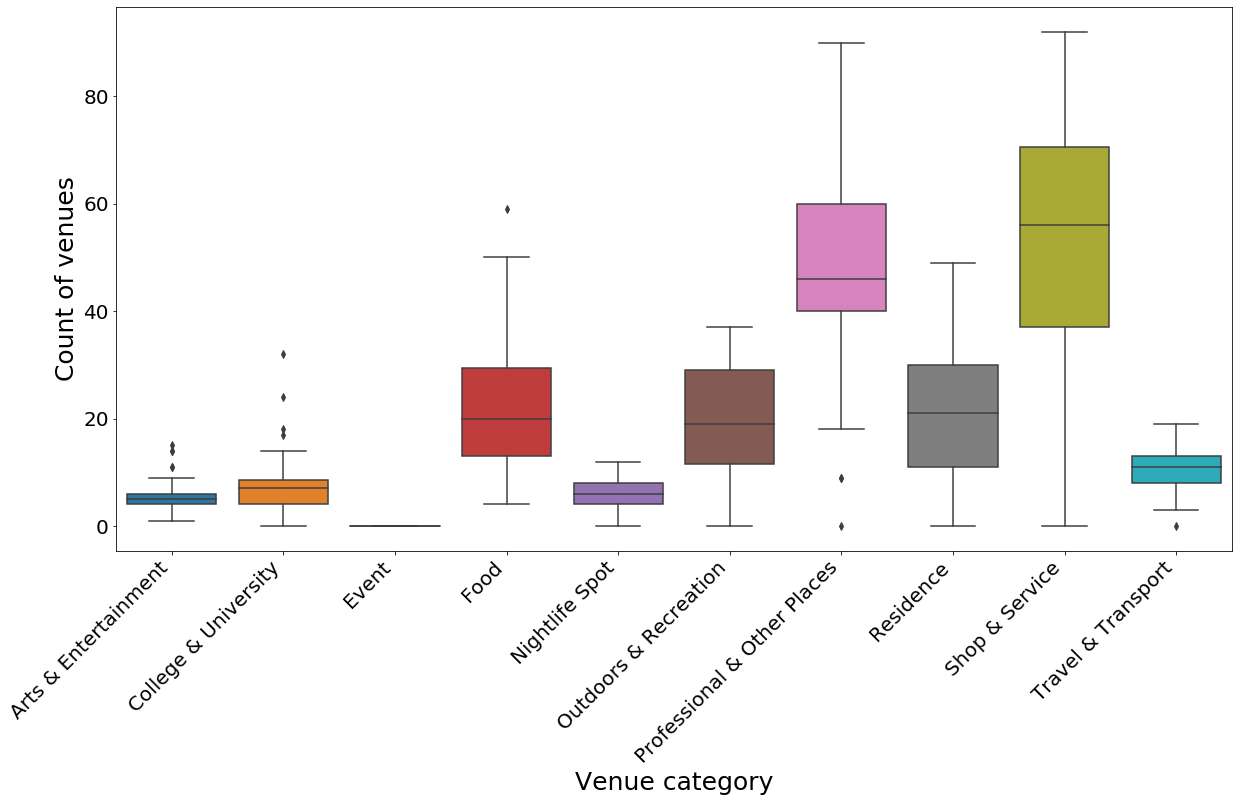

In [152]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [151]:
stations_venues_df

,Line,English name,Russian name,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1,Universitet,Университет,"55.6926,37.5333",15,24,0,45,11,28,80,35,68,14
1,1,Prospekt Vernadskogo,Проспект Вернадского,"55.6771,37.5060",11,32,0,50,7,33,90,38,75,10
2,1,Yugo-Zapadnaya,Юго-Западная,"55.6637,37.4833",4,8,0,44,6,18,88,4,59,15
3,1,Troparyovo,Тропарёво,"55.6459,37.4725",7,11,0,34,12,36,62,22,83,11
4,1,Rumyantsevo,Румянцево,"55.6330,37.4419",3,5,0,29,6,30,61,33,78,9
5,1,Salaryevo,Саларьево,"55.6227,37.4240",9,4,0,20,11,9,37,11,77,12
6,2,Tekhnopark,Технопарк,"55.6950,37.6641",6,8,0,11,4,26,40,15,43,12
7,2,Kolomenskaya,Коломенская,"55.6785,37.6638",7,12,0,20,5,18,47,27,52,14
8,2,Kashirskaya,Каширская,"55.6551,37.6487",4,8,0,35,9,31,69,21,70,17
9,2,Kantemirovskaya,Кантемировская,"55.6358,37.6564",6,2,0,28,11,37,61,30,66,17


Lets clear Event column as it has no venues at all.

In [153]:
stations_venues_df.drop('Event', 1, inplace=True)

In [132]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

Now lets normalize existing data.

In [162]:
from sklearn.preprocessing import MinMaxScaler

X = stations_venues_df.values[:,4:]
cluster_dataset = MinMaxScaler().fit_transform(X)

In [161]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df

,0,1,2,3,4,5,6,7
0,0.75000,0.745455,0.916667,0.756757,0.888889,0.714286,0.739130,0.736842
1,1.00000,0.836364,0.583333,0.891892,1.000000,0.775510,0.815217,0.526316
2,0.25000,0.727273,0.500000,0.486486,0.977778,0.081633,0.641304,0.789474
3,0.34375,0.545455,1.000000,0.972973,0.688889,0.448980,0.902174,0.578947
4,0.15625,0.454545,0.500000,0.810811,0.677778,0.673469,0.847826,0.473684
5,0.12500,0.290909,0.916667,0.243243,0.411111,0.224490,0.836957,0.631579
6,0.25000,0.127273,0.333333,0.702703,0.444444,0.306122,0.467391,0.631579
7,0.37500,0.290909,0.416667,0.486486,0.522222,0.551020,0.565217,0.736842
8,0.25000,0.563636,0.750000,0.837838,0.766667,0.428571,0.760870,0.894737
9,0.06250,0.436364,0.916667,1.000000,0.677778,0.612245,0.717391,0.894737


In [163]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1.000000,0.75000,0.745455,0.916667,0.756757,0.888889,0.714286,0.739130,0.736842
1,0.714286,1.00000,0.836364,0.583333,0.891892,1.000000,0.775510,0.815217,0.526316
2,0.214286,0.25000,0.727273,0.500000,0.486486,0.977778,0.081633,0.641304,0.789474
3,0.428571,0.34375,0.545455,1.000000,0.972973,0.688889,0.448980,0.902174,0.578947
4,0.142857,0.15625,0.454545,0.500000,0.810811,0.677778,0.673469,0.847826,0.473684


## Clustering

In [176]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English name'] = stations_venues_df['English name']
stations_clusters_minmax_df['Coordinates'] = stations_venues_df['Coordinates']

In [177]:
stations_clusters_minmax_df

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster,English name,Coordinates
0,1.000000,0.75000,0.745455,0.916667,0.756757,0.888889,0.714286,0.739130,0.736842,0,Universitet,"55.6926,37.5333"
1,0.714286,1.00000,0.836364,0.583333,0.891892,1.000000,0.775510,0.815217,0.526316,0,Prospekt Vernadskogo,"55.6771,37.5060"
2,0.214286,0.25000,0.727273,0.500000,0.486486,0.977778,0.081633,0.641304,0.789474,3,Yugo-Zapadnaya,"55.6637,37.4833"
3,0.428571,0.34375,0.545455,1.000000,0.972973,0.688889,0.448980,0.902174,0.578947,0,Troparyovo,"55.6459,37.4725"
4,0.142857,0.15625,0.454545,0.500000,0.810811,0.677778,0.673469,0.847826,0.473684,0,Rumyantsevo,"55.6330,37.4419"
5,0.571429,0.12500,0.290909,0.916667,0.243243,0.411111,0.224490,0.836957,0.631579,2,Salaryevo,"55.6227,37.4240"
6,0.357143,0.25000,0.127273,0.333333,0.702703,0.444444,0.306122,0.467391,0.631579,3,Tekhnopark,"55.6950,37.6641"
7,0.428571,0.37500,0.290909,0.416667,0.486486,0.522222,0.551020,0.565217,0.736842,3,Kolomenskaya,"55.6785,37.6638"
8,0.214286,0.25000,0.563636,0.750000,0.837838,0.766667,0.428571,0.760870,0.894737,0,Kashirskaya,"55.6551,37.6487"
9,0.357143,0.06250,0.436364,0.916667,1.000000,0.677778,0.612245,0.717391,0.894737,0,Kantemirovskaya,"55.6358,37.6564"


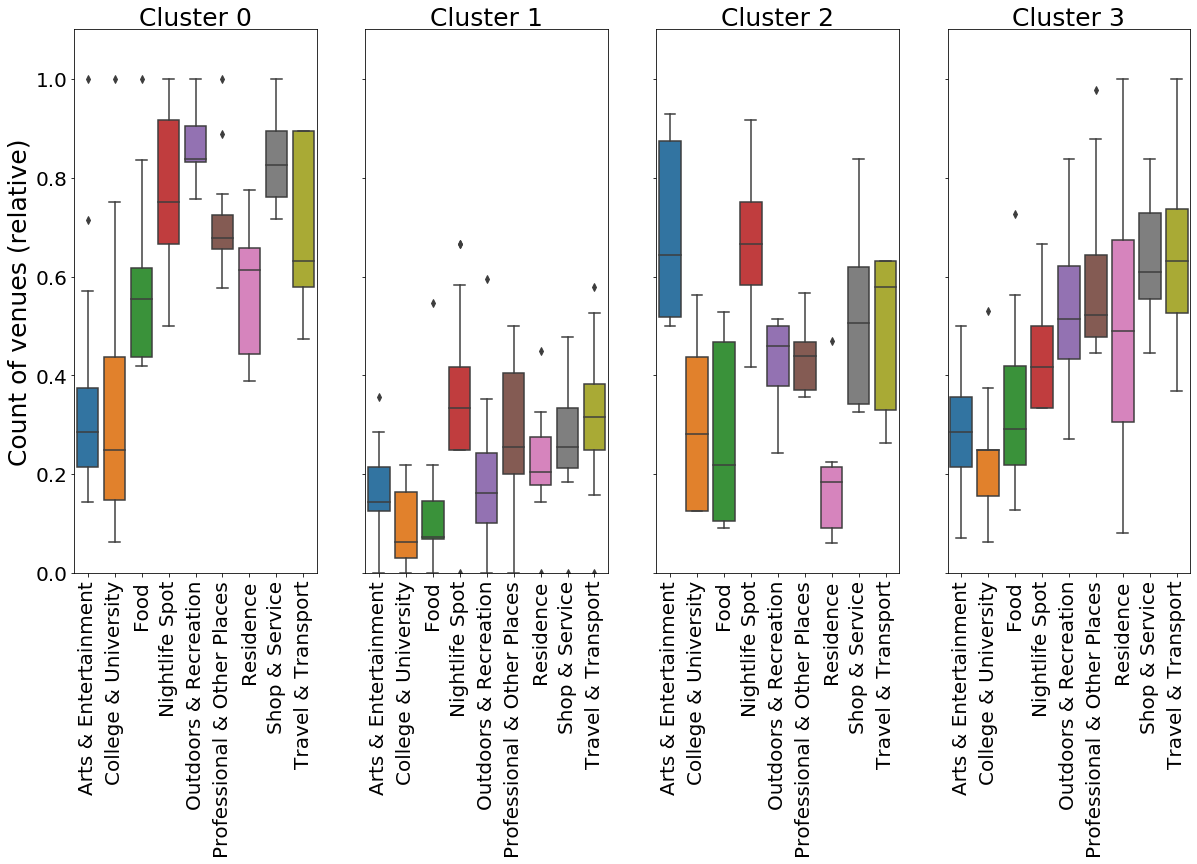

In [178]:

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Lets show the map with results for categories.

In [181]:
#create map of Moscow with all stations
map_moscow_metro = folium.Map(location=[55.755825, 37.617298], zoom_start=10)



#add markers
for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English name'],
                                         stations_clusters_minmax_df['Coordinates'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [float(x) for x in coordinates.split(',')]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['blue','green','orange','red']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=5,
        color=colors[cluster]
    ).add_to(map_moscow_metro)
    
map_moscow_metro

## Results


Here is how we can characterize the clusters by looking at venue scores

Cluster 0 (Blue) is leading in nightlife, shops and transport. This is the most diversely developed part of the city.

Cluster 1 (Green) is low in all categories. Those areas seem to be in industrial area.

Cluster 2 (Orange) is high in Arts, Entertainment and Food. It seems that this is a part of a town where people come to have fun.

Cluster 3 (Red) is leading in residences, shops and transport. Those are the places where people live.

Plotting the clusters on a map shows us that clusters are randomly situated around the town and there are no certain rules.


## Discussion


To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).




## Conclusion

Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.